In [4]:
# 安装依赖
!pip install --upgrade pip
!export PATH="/home/service/.local/bin:$PATH"
!pip install torchvision tqdm pillow -q

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.huaweicloud.com/repository/pypi/simple


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import io

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


In [8]:
import torch_npu
device = torch.device('npu:0' if torch.npu.is_available() else 'cpu')
print("Using device:", device)

/home/service/.local/lib/python3.10/site-packages/torch_npu/utils/path_manager.py:82: UserWarning: Warning: The /usr/local/Ascend/ascend-toolkit/latest owner does not match the current user.
  warnings.warn(f"Warning: The {path} owner does not match the current user.")
/home/service/.local/lib/python3.10/site-packages/torch_npu/utils/path_manager.py:82: UserWarning: Warning: The /usr/local/Ascend/ascend-toolkit/8.0.RC3/aarch64-linux/ascend_toolkit_install.info owner does not match the current user.
  warnings.warn(f"Warning: The {path} owner does not match the current user.")


Using device: npu:0


In [9]:
class DnCNNDataset(Dataset):
    def __init__(self, base_dataset, patch_size=32, sigma=25):
        self.base_dataset = base_dataset
        self.patch_size = patch_size
        self.sigma = sigma / 255.0  # 归一化

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx]  # Tensor 1xHxW
        c, h, w = img.shape
        top = random.randint(0, h - self.patch_size)
        left = random.randint(0, w - self.patch_size)
        patch = img[:, top:top+self.patch_size, left:left+self.patch_size]
        noise = torch.randn_like(patch) * self.sigma
        noisy_patch = patch + noise
        # 待修改为混合噪声
        noisy_patch = torch.clamp(noisy_patch, 0., 1.)
        return noisy_patch, patch

In [10]:
from torchvision import transforms
import torchvision.transforms.functional as F
from ImageDataset import ImageDataset as ID

# 先裁剪上方600x1024区域，再转为灰度图
transform_gray = transforms.Compose([
    # 裁剪：从顶部(0,0)开始，高度600，宽度1024
    transforms.Lambda(lambda x: F.crop(x, top=0, left=0, height=600, width=1024)),
    # 转换为灰度图（保持单通道）
    transforms.Lambda(lambda x: x.float().mean(dim=0, keepdim=True))
])

# 测试修改后的效果
aset = ID('Nanowires/annotation.csv', 'Nanowires', transform=transform_gray)
print(aset[0][0].shape, aset[0][1])  # 预期输出: torch.Size([1, 600, 1024]) ...
    

FileNotFoundError: [Errno 2] No such file or directory: 'Nanowires/annotation.csv'

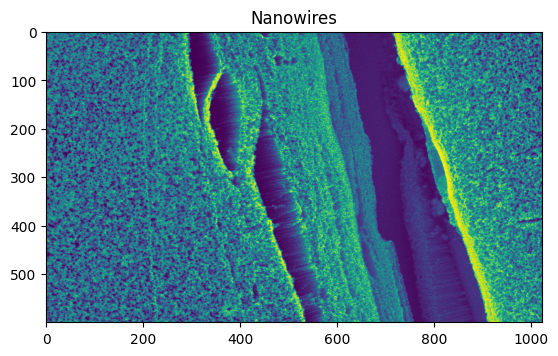

In [ ]:
# 测试
#import matplotlib.pyplot as plt
#img,lab=aset[100]
#img = img.permute(1, 2, 0)
#plt.imshow(img)
#plt.title(lab)
#plt.show()

In [23]:
# DnCNN模型改为单通道输入输出
class DnCNN(nn.Module):
    def __init__(self, channels=1, num_layers=17):
        super(DnCNN, self).__init__()
        layers = [nn.Conv2d(channels, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True)]
        for _ in range(num_layers - 2):
            layers += [
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
            ]
        layers.append(nn.Conv2d(64, channels, kernel_size=3, padding=1))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        return x - self.dncnn(x)

In [24]:
model = DnCNN(channels=1).to(device)

In [25]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [27]:
train_dataset = DnCNNDataset(aset, patch_size=32, sigma=25)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [28]:
num_epochs = 5
model.train()
for epoch in range(num_epochs):
    running_loss = 0
    for noisy, clean in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        noisy, clean = noisy.to(device), clean.to(device)
        output = model(noisy)
        loss = criterion(output, clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} average loss: {running_loss / len(train_loader):.6f}")

Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████████████████████| 58/58 [02:04<00:00,  2.15s/it]


Epoch 1 average loss: 12760.550647


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████████████████████| 58/58 [01:11<00:00,  1.23s/it]


Epoch 2 average loss: 9607.045014


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████████████████████| 58/58 [01:11<00:00,  1.24s/it]


Epoch 3 average loss: 6940.907041


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████████████████████| 58/58 [01:13<00:00,  1.26s/it]


Epoch 4 average loss: 5408.660447


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████████████████████| 58/58 [01:19<00:00,  1.37s/it]

Epoch 5 average loss: 4962.968300


In [31]:
torch.save(model.state_dict(), 'dncnn_gray_trained.pth')
print("训练完成，模型权重已保存为 dncnn_gray_trained.pth")

训练完成，模型权重已保存为 dncnn_gray_trained.pth


原图尺寸：768×1024


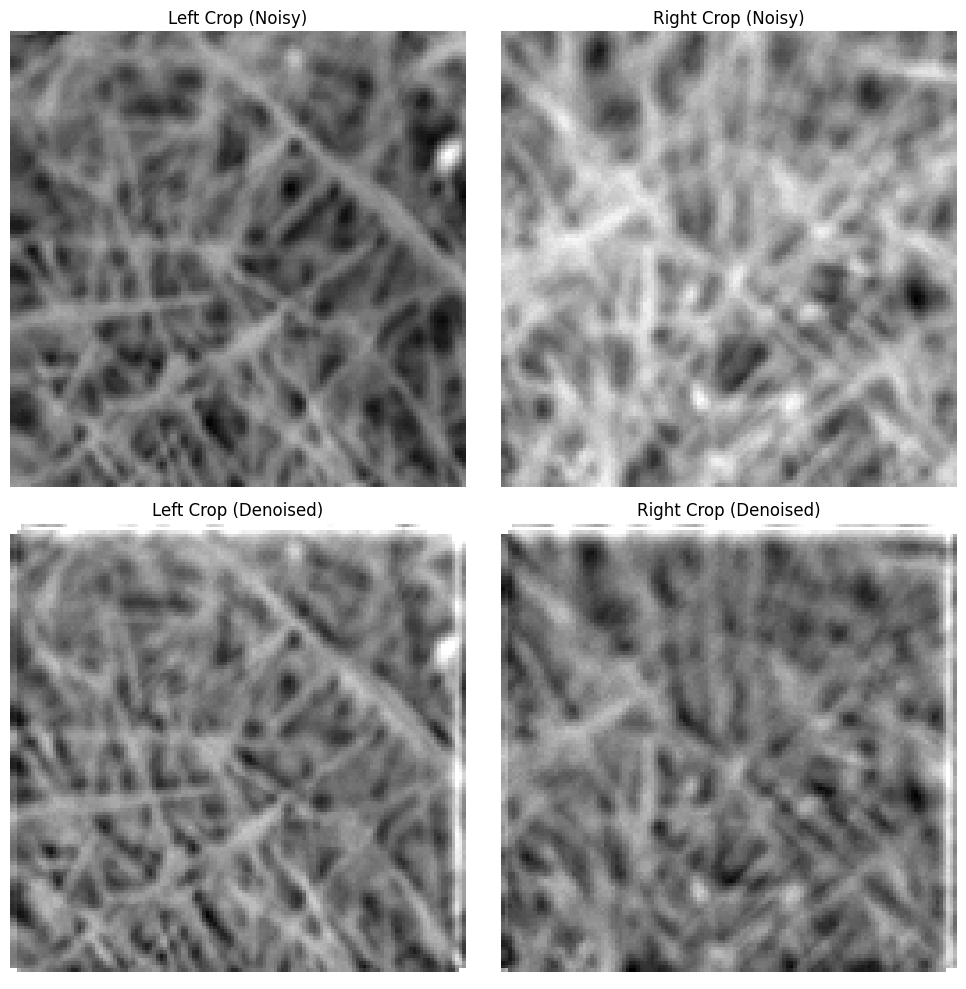

去噪结果已保存


In [36]:
import numpy as np
import matplotlib.pyplot as plt

# 单张灰度噪声图像去噪演示（裁剪区域版）
# 本地图像路径（请根据实际情况修改）
img_path = 'Nanowires\\L6_0a3e88ea0ac05134ea2e59621ed3e4bf.jpg'

# 加载图像并转为灰度图（不缩放，保持原图尺寸）
img = Image.open(img_path).convert('L')  # 'L'模式转为灰度图
img_np = np.array(img).astype(np.float32) / 255.0  # 归一化到[0,1]
h, w = img_np.shape  # 获取原图高和宽
print(f"原图尺寸：{h}×{w}")

# 定义裁剪尺寸（128×128）
crop_size = 128

# 检查原图是否足够大以裁剪128×128区域
if h < crop_size or w < crop_size * 2:  # 确保宽度至少能容纳两个128区域
    raise ValueError(f"原图尺寸过小，无法裁剪两个128×128区域（当前尺寸：{h}×{w}）")

# 裁剪左上角区域（坐标：(0,0)到(crop_size, crop_size)）
crop_left = img_np[:crop_size, :crop_size]
# 裁剪右上角区域（坐标：(0, w-crop_size)到(crop_size, w)）
crop_right = img_np[:crop_size, w - crop_size:]

# 转换为模型输入格式（添加批次维度和通道维度）
# 假设device已定义（如device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')）
input_left = torch.from_numpy(crop_left).unsqueeze(0).unsqueeze(0).to(device)
input_right = torch.from_numpy(crop_right).unsqueeze(0).unsqueeze(0).to(device)

# 模型推理（去噪）
model.eval()  # 切换到评估模式
with torch.no_grad():  # 禁用梯度计算，加速推理
    denoised_left = model(input_left).clamp(0, 1)  # 左上角去噪结果
    denoised_right = model(input_right).clamp(0, 1)  # 右上角去噪结果

# 转换回numpy数组
denoised_left_np = denoised_left.squeeze().cpu().numpy()
denoised_right_np = denoised_right.squeeze().cpu().numpy()

# 显示原图裁剪区域和去噪结果（4幅图对比：左原图-左去噪-右原图-右去噪）
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2行2列布局

# 左上角原图
axs[0, 0].imshow(crop_left, cmap='gray')
axs[0, 0].set_title("Left Crop (Noisy)")
axs[0, 0].axis('off')

# 左上角去噪结果
axs[1, 0].imshow(denoised_left_np, cmap='gray')
axs[1, 0].set_title("Left Crop (Denoised)")
axs[1, 0].axis('off')

# 右上角原图
axs[0, 1].imshow(crop_right, cmap='gray')
axs[0, 1].set_title("Right Crop (Noisy)")
axs[0, 1].axis('off')

# 右上角去噪结果
axs[1, 1].imshow(denoised_right_np, cmap='gray')
axs[1, 1].set_title("Right Crop (Denoised)")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

# 保存两块去噪结果
denoised_left_img = (denoised_left_np * 255).astype(np.uint8)
denoised_right_img = (denoised_right_np * 255).astype(np.uint8)

save_left = "denoised_left.png"
save_right = "denoised_right.png"
Image.fromarray(denoised_left_img).save(save_left)
Image.fromarray(denoised_right_img).save(save_right)
print("去噪结果已保存")